# Домашняя работа. Яндекс.Маркет. Часть 2

Задача: увеличение LTV за счет уменьшения оттока пользователей и увеличения частоты контакта<br>

Ключевые этапы решения:
1. Обработать данные<br>
2. Сделать RFM-анализ<br>
3. Подготовить рекомендации команде сервиса<br>
4. Предложить проект по увеличению LTV и оценить потенциальную пользу от этого проекта

Подготовим датафрейм под критерии для RFM анализа

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.interpolate import interp1d
import seaborn as sns
import squarify

In [3]:
rfm = pd.read_csv('/Users/mac/Downloads/rfm.tsv', sep='\t', header = None, encoding='latin-1', index_col=False, names=['hit timestamp','user_id','url','geo_id','category','price'], low_memory=False)

In [4]:
rfm['hit timestamp'] = pd.to_datetime(rfm['hit timestamp'], unit='s') 
rfm['hit timestamp'] = rfm['hit timestamp'].astype(str).str.split(' ').str[0]
rfm = rfm.drop('url', axis=1)
rfm = rfm.drop('geo_id', axis=1)
rfm = rfm.drop('category', axis=1)
rfm = rfm.fillna(0)
rfm = rfm[rfm['price']>0]

In [5]:
rfm.head()

,hit timestamp,user_id,price
64,2013-03-16,00023fcc5c93cb4674bdad0d448272e6,30.0
65,2013-03-13,00023fcc5c93cb4674bdad0d448272e6,10.0
66,2013-03-14,00023fcc5c93cb4674bdad0d448272e6,10.0
67,2013-03-14,00023fcc5c93cb4674bdad0d448272e6,10.0
68,2013-03-13,00023fcc5c93cb4674bdad0d448272e6,80.0


In [6]:
rfm['user_id'].unique().size

55263

In [7]:
rfm = rfm.rename(columns = {'hit timestamp':'order_date'})
rfm = rfm.rename(columns = {'price':'order_value'})

In [8]:
rfm.shape, rfm.head()

((363181, 3),
     order_date                           user_id  order_value
 64  2013-03-16  00023fcc5c93cb4674bdad0d448272e6         30.0
 65  2013-03-13  00023fcc5c93cb4674bdad0d448272e6         10.0
 66  2013-03-14  00023fcc5c93cb4674bdad0d448272e6         10.0
 67  2013-03-14  00023fcc5c93cb4674bdad0d448272e6         10.0
 68  2013-03-13  00023fcc5c93cb4674bdad0d448272e6         80.0)

In [9]:
rfm = rfm[['user_id', 'order_date', 'order_value']] 

In [10]:
rfm.head()

,user_id,order_date,order_value
64,00023fcc5c93cb4674bdad0d448272e6,2013-03-16,30.0
65,00023fcc5c93cb4674bdad0d448272e6,2013-03-13,10.0
66,00023fcc5c93cb4674bdad0d448272e6,2013-03-14,10.0
67,00023fcc5c93cb4674bdad0d448272e6,2013-03-14,10.0
68,00023fcc5c93cb4674bdad0d448272e6,2013-03-13,80.0


In [11]:
rfm.to_csv('/Users/mac/Downloads/rfmizer-master/input_file.csv', index=False)

# 2. RFM анализ

RFM анализом разделим клиентов на 125 сегментов по сочетанию параметров:<br>
1. Давность покупки R (1-5)<br>
2. Частота покупки F (1-5)<br>
3. Сумма покупки M (1-5)<br>

где 5 - самый высокий, а 1 - самый низкий. Клиентами, находящимися на вершине всех трех критериев, будут наиболее значимые клиенты

Для сегментации используем библиотеку python RFMizer (https://github.com/Slony/rfmizer)

Получаем файл mapping

In [12]:
mapping = pd.read_csv('/Users/mac/Downloads/rfmizer-master/output_file_mapping.csv')

In [13]:
mapping.head()

,user_id,frequency,monetary,recency
0,6c98e1c622cf9abb6fc429f4e3b8cf1d,2,2,4
1,81766ff2097155ab4930a172ed2db864,1,5,3
2,4a5dcd2cb138577b114f1c691a168261,3,2,5
3,4e4a7e2b5a7016371defdcd1399d49b3,1,5,3
4,e9a0066e9a7fe5627f276b8adfc141fc,1,1,1


In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

In [15]:
rfm1 = pd.read_csv('/Users/mac/Downloads/rfmizer-master/input_file.csv')

<br>
<br>
Визуализируем заказы по дням

In [16]:
count_user_date_rfm1 = rfm1.groupby('order_date', as_index = False).user_id.count()
trace = go.Bar(x = count_user_date_rfm1.order_date, y = count_user_date_rfm1.user_id)
layout = go.Layout(title='Заказы по дням')
fig = go.Figure(data = [trace], layout = layout) 
iplot(fig)

<br>
<br>
Визуализируем заказы по дням

In [17]:
count_order_date_rfm1 = rfm1.groupby('order_date', as_index = False).order_value.sum()
trace = go.Bar(x = count_order_date_rfm1.order_date, y = count_order_date_rfm1.order_value)
layout = go.Layout(title='Выручка по дням')
fig = go.Figure(data = [trace], layout = layout) 
iplot(fig)

<br>
<br>
Визуализируем Заказы и Выручку по дням

In [18]:
compare_userid_rfm1 = rfm1.groupby('order_date', as_index = False).user_id.count() 
compare_value_rfm1 = rfm1.groupby('order_date', as_index = False).order_value.sum()

In [19]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

In [20]:
fig.add_trace(go.Scatter(x = compare_userid_rfm1.order_date, y = compare_userid_rfm1.user_id, name = 'Заказы'),secondary_y=False)
fig.add_trace(go.Scatter(x = compare_value_rfm1.order_date, y = compare_value_rfm1.order_value, name = 'Выручка'),secondary_y=True)
fig.update_layout(title_text="Заказы и выручка по дням")

In [21]:
fig.update_xaxes(title_text="Дни") # x-axis
fig.update_yaxes(title_text="Заказы", secondary_y=False) # y-axes 
fig.update_yaxes(title_text="Выручка", secondary_y=True)
fig.show()

<br>
<br>
Визуализацируем количество пользователей по сегментам 1, 2, 3 каждого параметра R-F-M

In [22]:
count_frequency_mapping = mapping.groupby('frequency', as_index = False).user_id.count() 
count_monetary_mapping = mapping.groupby('monetary', as_index = False).user_id.count() 
count_recency_mapping = mapping.groupby('recency', as_index = False).user_id.count()

In [23]:
trace_frequency = go.Bar(x = count_frequency_mapping.frequency, y = count_frequency_mapping.user_id, name = 'frequency')

In [24]:
trace_monetary = go.Bar(x = count_monetary_mapping.monetary, y = count_monetary_mapping.user_id, name = 'monetary')

In [25]:
trace_recency = go.Bar(x = count_recency_mapping.recency, y = count_recency_mapping.user_id, name = 'recency')

In [26]:
layout = go.Layout(title='Количество пользователей по сегментам 1, 2, 3 каждого параметра R-F-M')

In [27]:
fig = go.Figure(data = [trace_recency, trace_frequency, trace_monetary], layout = layout) 
iplot(fig)

<br>
<br>
Визуализируем сколько пользователей находится в каждом из сегментов RFM

In [28]:
import plotly.express as px

In [29]:
tips = mapping.groupby(['recency', 'frequency','monetary'], as_index = False).user_id.count() 
fig = px.scatter(tips, x="frequency", y="recency", color="user_id", size='user_id', facet_col="monetary", render_mode="webgl") 
fig.update_yaxes(dtick=1)
fig.show()

In [30]:
mapping['RFM'] = mapping[['recency', 'frequency', 'monetary']].apply(lambda x: ''.join(map(str, x)), axis=1)
mapping['RFM'] = mapping['RFM'].astype('int')

In [31]:
mapping.head()

,user_id,frequency,monetary,recency,RFM
0,6c98e1c622cf9abb6fc429f4e3b8cf1d,2,2,4,422
1,81766ff2097155ab4930a172ed2db864,1,5,3,315
2,4a5dcd2cb138577b114f1c691a168261,3,2,5,532
3,4e4a7e2b5a7016371defdcd1399d49b3,1,5,3,315
4,e9a0066e9a7fe5627f276b8adfc141fc,1,1,1,111


<br>
<br>
Количество пользователей по каждому сегменту (количественно)

In [32]:
mapping_filter = mapping.groupby('RFM')['user_id'].count() 
segments = pd.DataFrame(mapping_filter)

Text(0.5, 1.0, 'segments')

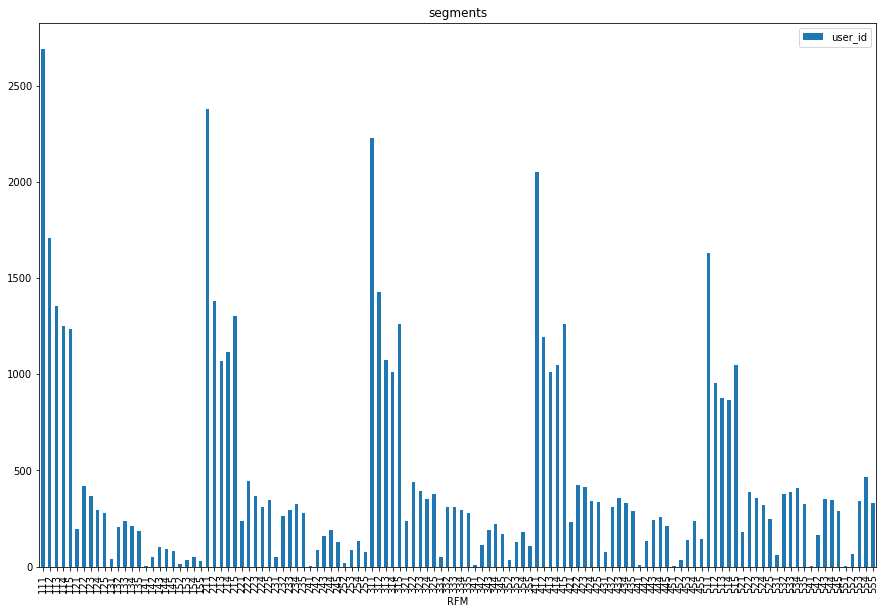

In [33]:
segments.plot(kind="bar", figsize=(15, 10))
plt.title("segments") 

<br>
<br>
Определим RFM level у каждого пользователя

In [34]:
def rfm_level(i):
    
    if i in [555, 554, 544, 545, 454, 455, 445]:
        return 'Champions'
    elif i in [543, 444, 435, 355, 354, 345, 344, 335]:
        return 'Loyal'
    elif i in [553, 551, 552, 541,542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323]:
        return 'Potential_Loyalist'
    elif i in [512, 511, 422, 421, 412, 411, 311]:
        return 'New_Customers'
    elif i in [525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313]:
        return 'Promising'
    elif i in [535, 534, 443, 434, 343, 334, 325, 324]:
        return 'Need_Attention'
    elif i in [331, 321, 312, 221, 213, 231, 241, 251]:
        return 'About_To_Sleep'
    elif i in [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124]:
        return 'At_Risk'
    elif i in [155, 154, 144, 214,215,115, 114, 113]:
        return 'Cannot_Lose_Them'
    elif i in [332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211]:
        return 'Hibernating_customers'
    elif i in [111, 112, 121, 131,141,151]:
        return 'Lost_customers'
    else: return "none22"

#mapping['RFM_Level'] = mapping.apply(rfm_level, axis=1)
# mapping.head()

In [35]:
rfm_level(254)
mapping['RFM_Level'] = mapping['RFM'].apply(rfm_level)
mapping.head()

,user_id,frequency,monetary,recency,RFM,RFM_Level
0,6c98e1c622cf9abb6fc429f4e3b8cf1d,2,2,4,422,New_Customers
1,81766ff2097155ab4930a172ed2db864,1,5,3,315,Promising
2,4a5dcd2cb138577b114f1c691a168261,3,2,5,532,Potential_Loyalist
3,4e4a7e2b5a7016371defdcd1399d49b3,1,5,3,315,Promising
4,e9a0066e9a7fe5627f276b8adfc141fc,1,1,1,111,Lost_customers


<br>
<br>
Вычислим средние значения для каждого RFM_Level и отобразим размер каждого сегмента

In [42]:
rfm_level_agg = mapping.groupby('RFM_Level').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': ['mean', 'count']}).round(1)
rfm_level_agg

recency frequency monetary       
                         mean      mean     mean  count
RFM_Level                                              
About_To_Sleep            2.6       1.2      2.2   3074
At_Risk                   1.6       3.1      4.1   3635
Cannot_Lose_Them          1.4       1.1      4.2   6430
Champions                 4.7       4.6      4.5   2026
Hibernating_customers     2.0       1.6      1.8   6870
Lost_customers            1.0       1.1      1.4   4637
Loyal                     3.7       3.8      4.3   1859
Need_Attention            3.8       2.9      4.1   2528
New_Customers             4.0       1.1      1.3   8706
Potential_Loyalist        4.1       3.3      2.6   3868
Promising                 4.1       1.2      4.0  11630

In [43]:
counts_1 = [3074, 3635, 6430, 2026, 6870, 4637, 1859, 2528, 8706, 3868, 11630]

In [44]:
share = []

for i in counts_1:
    s = float(i) / 55263
    share.append(s)

In [45]:
share

[0.05562492083310714,
 0.06577637840870021,
 0.11635271338870493,
 0.036661057126829884,
 0.124314640898974,
 0.08390785878435843,
 0.03363914373088685,
 0.04574489260445506,
 0.15753759296455133,
 0.06999258093118362,
 0.21044822032824856]

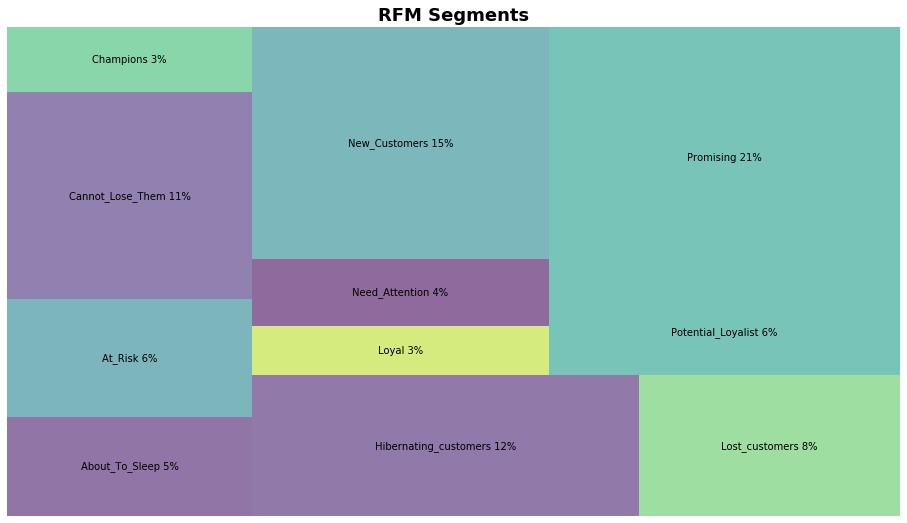

In [46]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], label=['About_To_Sleep 5%', 'At_Risk 6%', 'Cannot_Lose_Them 11%', 'Champions 3%', 'Hibernating_customers 12%', 'Lost_customers 8%', 'Loyal 3%', 'Need_Attention 4%', 'New_Customers 15%', 'Potential_Loyalist 6%', 'Promising 21%'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<br>
<br>
<br>
<br>

# 3. Summery и Рекомендации

Champions<br>
Купил недавно, заказывает часто и тратит больше всех<br>
Можно наградить, например, дать доступ на хакрытую распродажу. Также они могут продвигать Маркет купонами друзьям<br>
<br>
Loyal<br>
Заказывают регулярно. Отзывчивы к акциям.<br>
Продавать более дорогие продукты. Спрашивать отзывы.<br>
<br>
Potential_Loyalist<br>
Недавние клиенты и потратили хорошую сумму.<br>
Предложить программу лояльности. Предложить персональные рекомендации.<br>
<br>
New_Customers<br>
Купили совсем недавно.<br>
Обеспечить поддержку, начать строить отношения.<br>
<br>
Promising<br>
Potential_Loyalist несколько месяцев назад. Тратит часто и хорошую сумму. Но последняя покупка была несколько недель назад.<br>
Возвращаем их на Маркет и предлагаем персональные рекомендации. Предлагаем купоны<br>
<br>
Need_Attention<br>
Клиенты, чья последняя покупка произошла более месяца назад.<br>
Предложение с ограниченным временем. Предлагаем персональные рекомендации.<br>
<br>
Cannot_Lose_Them<br>
Делали самые крупные заказы и часто. Но давно не возвращались.<br>
Вернуть можно рассылкой о новых/ограниченных продуктах. Поговорить с ними, если это возможно. Потратить время на максимально возможную персонализацию.<br>
<br>
At_Risk<br>
Похож на Cannot_Lose_Them, но с меньшей денежной и частотной ценностью.<br>
Отправить персонализированные электронные письма.<br>
<br>
Hibernating_customers<br>
Сделали свою последнюю покупку давным-давно<br>
Вернуть их интерес с помощью конкретной скидки на конкретный продукт.<br>
<br>
Lost<br>
Потерянные<br>
Лучше не тратить средства и время
<br>
<br>
<br>
<br>
<br>

# 4. Посчитаем эффект 

Предлагаю рассмотреть группу Promising их доля составляет 21% (больше всех)<br>
Это группа пользователей, которые тратят часто и на большую сумму, но их давно не было.<br>
Promising - основная группа на отток(!).<br>

Допустим, что мы разослали персональные предложения со скидкой по e-mail

In [48]:
ARPU = 34
Paying_Share = 0.184
Group_customer = 11630

In [49]:
effect = ARPU * Group_customer * Paying_Share

In [51]:
print('Примерный дополнительный эффект от возвращения группы Promising: {} ед.'.format(effect))

Примерный дополнительный эффект от возвращения группы Promising: 72757.28 ед.
